In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.stats import gaussian_kde
from tqdm import tqdm

In [18]:
# define the target potential V and its gradient
def V(x):
    return (x[0]**4 + x[1]**4) / 4 - (x[0]**2 + x[1]**2) / 2

def grad_V(x):
    return np.array([
        x[0]**3 - x[0],
        x[1]**3 - x[1]
    ])

In [19]:
# rbf kernel and its gradient
def svgd_kernel(theta, h=-1):
    sq_dist = squareform(pdist(theta)) ** 2
    if h < 0:
        h = np.sqrt(0.5 * np.median(sq_dist) / np.log(theta.shape[0] + 1))
    K = np.exp(-sq_dist / (2 * h**2))
    grad_K = - (K @ theta) + theta * np.sum(K, axis=1, keepdims=True)
    grad_K /= h**2
    return K, grad_K

In [20]:
# svgd update
def svgd_update(particles, grad_V, n_iter, stepsize=1e-2, n_frame=5):
    theta = np.copy(particles)
    historical_grad = 0
    saved_particles = []
    save_every = n_iter // (n_frame - 1)
    fudge = 1e-6
    for i in range(n_iter + 1):
        # applica gradiente punto per punto
        grad_vals = np.array([ -grad_V(x) for x in theta ])
        K, grad_K = svgd_kernel(theta)
        grad_theta = (K @ grad_vals + grad_K) / theta.shape[0]
        if i == 0:
            historical_grad = grad_theta**2
        else:
            historical_grad = 0.9 * historical_grad + 0.1 * grad_theta**2
        adj_grad = grad_theta / (fudge + np.sqrt(historical_grad))
        theta += stepsize * adj_grad
        if i % save_every == 0:
            saved_particles.append((i, np.copy(theta)))
    return theta, saved_particles


In [21]:
# initialize particles
N = 3000
np.random.seed(0)
initial_particles = np.random.randn(N, 2)

In [22]:
# run svgd
final_particles, frames = svgd_update(initial_particles, grad_V, n_iter=50, n_frame=3)

In [23]:
# defining the grid for densities
x = np.linspace(-3, 3, 200)
y = np.linspace(-3, 3, 200)
X1, X2 = np.meshgrid(x, y)
grid_points = np.vstack([X1.ravel(), X2.ravel()]).T

# target density
Z = np.exp(-np.array([V(x) for x in grid_points])).reshape(X1.shape)
Z /= np.trapz(np.trapz(Z, x), y)

# initial and final KDE
kde_init = gaussian_kde(initial_particles.T)
Z_init = kde_init(grid_points.T).reshape(X1.shape)

kde_final = gaussian_kde(final_particles.T)
Z_final = kde_final(grid_points.T).reshape(X1.shape)

/var/folders/gd/b2d40bms7s3f8y4f31x7pk1r0000gn/T/ipykernel_32998/2682089999.py:9: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Z /= np.trapz(np.trapz(Z, x), y)


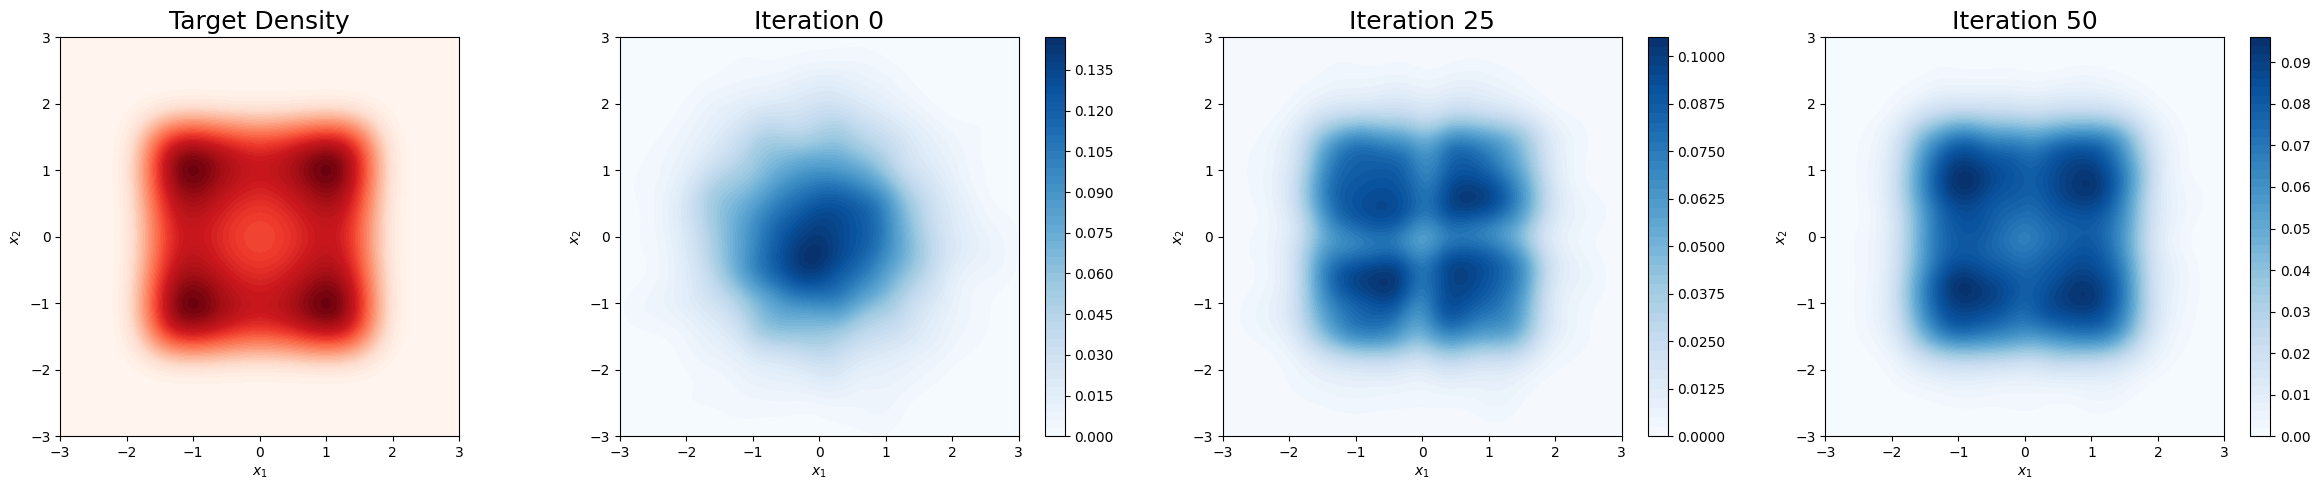

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

axes[0].contourf(X1, X2, Z, levels=50, cmap='Reds')
axes[0].set_title('Target Density', fontsize=18)
axes[0].set_xlabel('$x_1$')
axes[0].set_ylabel('$x_2$')
axes[0].set_aspect('equal')

for ax, (step, part), title in zip(
    axes[1:], frames,
    [f'Iteration {frames[0][0]}',
     f'Iteration {frames[1][0]}',
     f'Iteration {frames[2][0]}']
):
    kde = gaussian_kde(part.T)
    Z_kde = kde(grid_points.T).reshape(X1.shape)
    pcm = ax.contourf(X1, X2, Z_kde, levels=50, cmap='Blues')
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_aspect('equal')
    fig.colorbar(pcm, ax=ax)

plt.tight_layout()
plt.show()